### 텍스트 머신러닝 단계

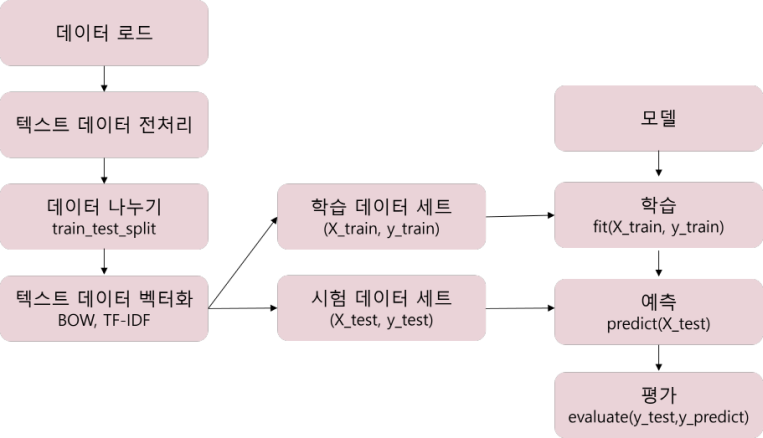




In [1]:
!pip install koreanize_matplotlib
!pip install konlpy --upgrade
!pip install tqdm --upgrade

!pip install wordcloud

!pip install pecab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 37.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 18.1 MB/s eta 0:00:00
  Created wheel for pecab: filename=pecab-1.0.8-py3-none-any.whl size=26646664 sha256=1da787d4a14d0382c3406d0578dc89048ac92d8c2a2c718dbdca2fdedfe8a390
  Stored in directory: /root/.cache/pip/wheels/5c/6f/b4/ab61b8863d7d8b1409def8ae31adcaa089fa91b8d022ec309d
Successfully built pecab


In [2]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 한글 폰트 설정
import koreanize_matplotlib

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 1. 데이터 로드

- https://dacon.io/competitions/official/235747/data
  - train_data.csv, test_data.csv, sample_submission.csv, topic_dict.csv
  - 뉴스 데이터는 분류형 데이터에 속함

In [4]:
# 학습 / 시험 데이터 세트를 읽어서 train 과 test 변수에 입력

train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/텍스트마이닝/data/train_data.csv')
test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/텍스트마이닝/data/test_data.csv')
train.shape, test.shape

((45654, 3), (9131, 2))

In [5]:
# 토픽 불러오기

topic = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/텍스트마이닝/data/topic_dict.csv')
topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [6]:
# 정답이 레이블링 되어 있는 연습문제

train.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [7]:
test.head()

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간


In [8]:
train['topic_idx'].value_counts()

topic_idx
4    7629
2    7362
5    6933
6    6751
1    6222
3    5933
0    4824
Name: count, dtype: int64

In [9]:
topic.index

RangeIndex(start=0, stop=7, step=1)

## 2. 텍스트 데이터 전처리



### 1) 문자 길이, 단어의 등장 빈도 확인 후 시각화 : 데이터 특성 파악

In [10]:
# df 합치기 - concat(), merge()

raw = pd.concat([train, test])
raw.shape

(54785, 3)

In [11]:
raw.tail()

,index,title,topic_idx
9126,54780,인천 오후 3시35분 대설주의보…눈 3.1cm 쌓여,NaN
9127,54781,노래방에서 지인 성추행 외교부 사무관 불구속 입건종합,NaN
9128,54782,40년 전 부마항쟁 부산 시위 사진 2점 최초 공개,NaN
9129,54783,게시판 아리랑TV 아프리카개발은행 총회 개회식 생중계,NaN
9130,54784,유영민 과기장관 강소특구는 지역 혁신의 중심…지원책 강구,NaN


- test 데이터 셋에는 topic_idx 가 없었기 때문에 NaN 이 나오는 것을 볼 수 있음

In [12]:
# how : 붙이는 기준
df = raw.merge(topic, how='left')
df.shape

(54785, 4)

### 정답값 빈도수

In [13]:
# topic_idx : NaN 값이 들어있기 때문에 float 형태로 idx 값 나옴

df['topic_idx'].value_counts()

topic_idx
4.0    7629
2.0    7362
5.0    6933
6.0    6751
1.0    6222
3.0    5933
0.0    4824
Name: count, dtype: int64

In [14]:
df['topic'].value_counts()

topic
세계      7629
사회      7362
스포츠     6933
정치      6751
경제      6222
생활문화    5933
IT과학    4824
Name: count, dtype: int64

In [15]:
# 점유율
df['topic'].value_counts(normalize=True)

topic
세계      0.167105
사회      0.161256
스포츠     0.151860
정치      0.147873
경제      0.136286
생활문화    0.129956
IT과학    0.105664
Name: proportion, dtype: float64

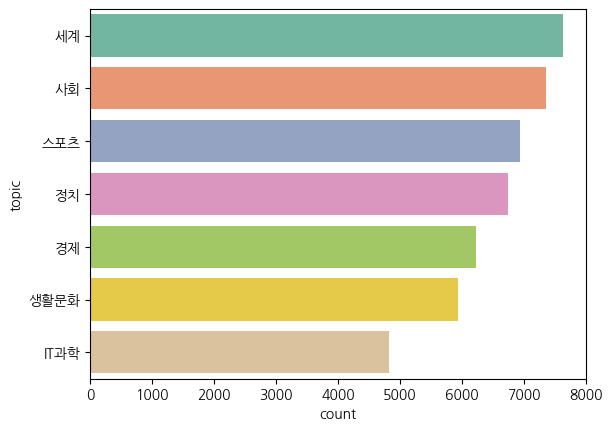

In [16]:
sns.countplot(data=df, y='topic',order=df['topic'].value_counts().index, palette='Set2');

- 뉴스 기사의 토픽별로 '세계'에 해당하는 문서가 가장 많고, IT 과학에 해당하는 문서가 가장 적음
- 데이터의 불균형을 어떻게 처리할 것인가?

### 문자 길이 및 글자의 빈도와 단어수 빈도수
> 문자 길이 확인
  - 문자 길이가 긴 텍스트는 의미를 학습하기에 충분하고, 길이가 짧으면 불충분하기 때문에 확인 필요
  - 혹은 학습완료 후 성능 향상을 위한 계획을 세울 때 단어 빈도 또는 문자 길이 등을 유용하게 사용

> 글자의 빈도와 단어의 빈도수 확인 단계
  - ① 음절 길이(len)와 단어 빈도(word_count)등의 빈도수를 다음과 같이 데이터 프레임에 넣는다
  - ② len()으로 낱글자의 길이 세기
  - ③ split()을 사용해 공백을 기준으로 한 어절(토큰)의 길이 세기
  - ④ 중복 없이 등장하는 어절의 길이는 집합형인 set 사용

> split()을 사용해 공백을 기준으로 한 어절(토큰)의 길이 세기 예시
 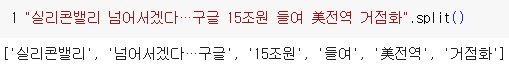

In [17]:
# title 길이
df['len'] = df['title'].map(lambda x:len(x))

In [18]:
# word_count 길이 : 공백기준

df['word_count'] = df['title'].map(lambda x:len(x.split()))

In [19]:
# unique_word_count : 공백으로 잘라진 단어 중 unique 개수

df['unique_word_count'] = df['title'].map(lambda x:len(np.unique(x.split())))

In [20]:
df.head()

,index,title,topic_idx,topic,len,word_count,unique_word_count
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4.0,세계,24,5,5
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4.0,세계,30,6,6
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4.0,세계,30,8,8
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4.0,세계,32,7,7
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4.0,세계,25,7,7


> **시각화**

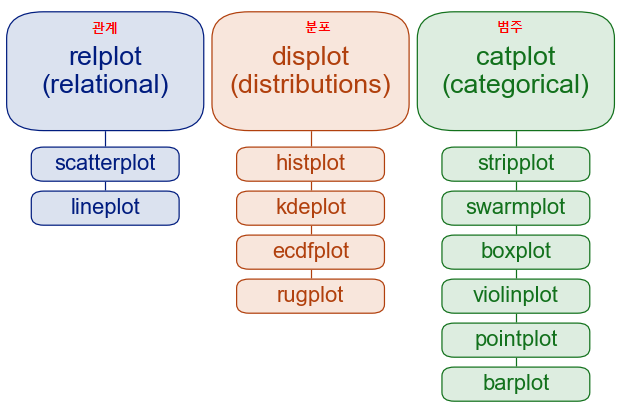

https://seaborn.pydata.org/tutorial/function_overview.html

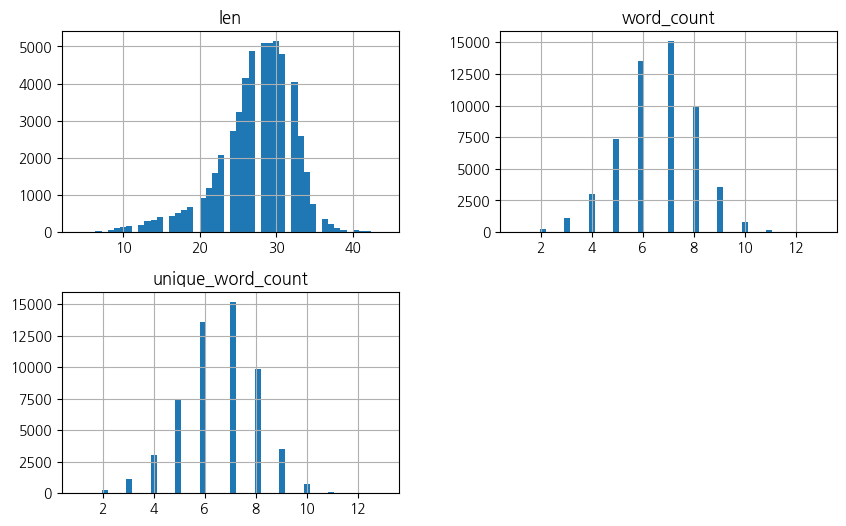

In [21]:
df.iloc[:, -3:].hist(bins=50, figsize=(10,6));

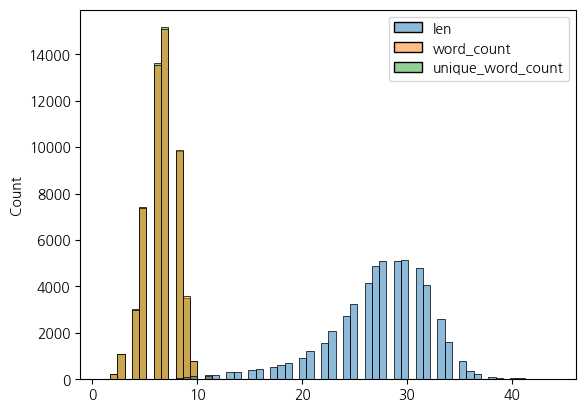

In [22]:
sns.histplot(df.iloc[:,-3:]);

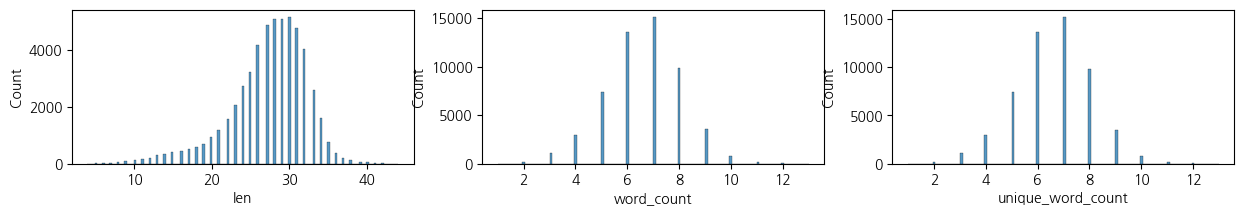

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15,2))
sns.histplot(df["len"], ax = axes[0]);
sns.histplot(df["word_count"], ax = axes[1]);
sns.histplot(df["unique_word_count"], ax = axes[2]);

- 연합뉴스 기사에서 제목만 추출 : 20~30 개 사이에 빈도수가 몰려 있음
- 단어 수도 6~8 개 내외

In [24]:
df[['len','word_count','unique_word_count']].describe()

,len,word_count,unique_word_count
count,54785.000000,54785.000000,54785.000000
mean,27.318846,6.587880,6.576198
std,4.947738,1.471852,1.465320
min,4.000000,1.000000,1.000000
25%,25.000000,6.000000,6.000000
50%,28.000000,7.000000,7.000000
75%,31.000000,8.000000,8.000000
max,44.000000,13.000000,13.000000


> 토픽별 글자와 단어의 빈도 확인

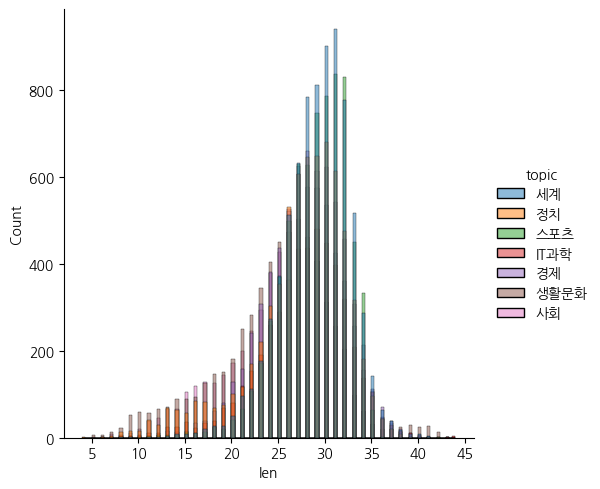

In [25]:
sns.displot(data=df, x="len", hue="topic", kind="hist");

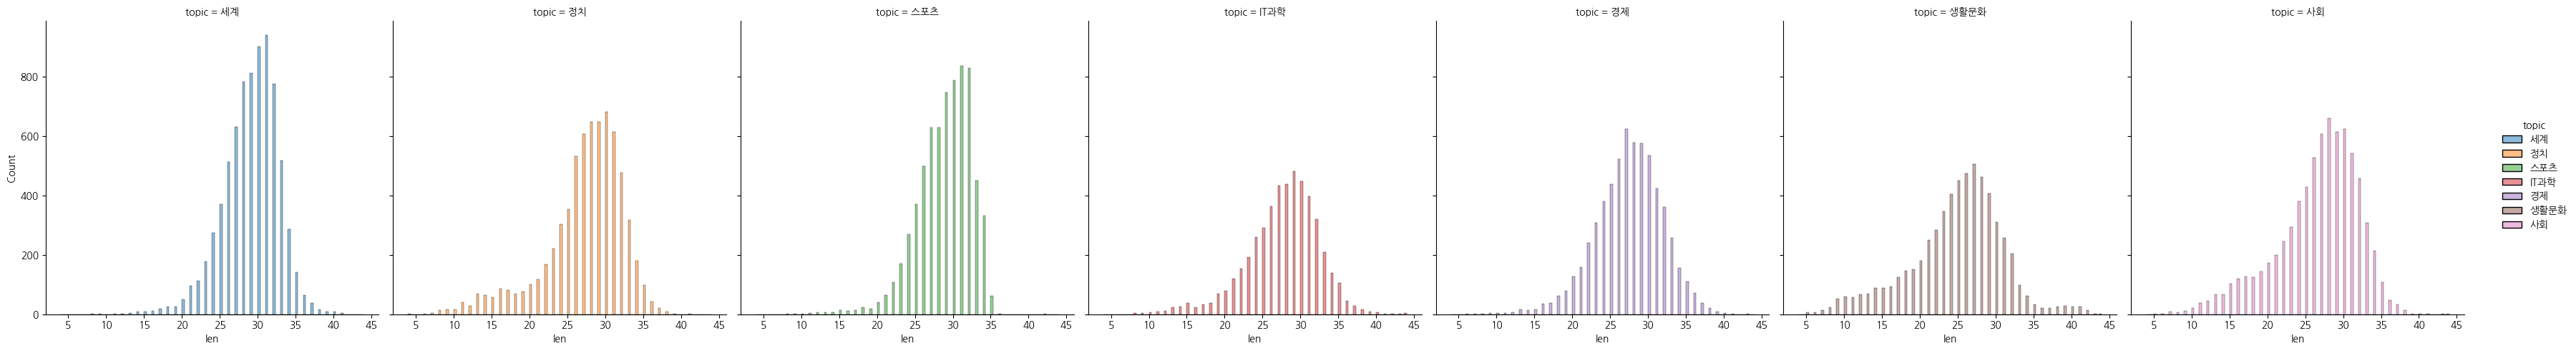

In [26]:
sns.displot(data=df, x="len", hue="topic", kind="hist", col="topic");

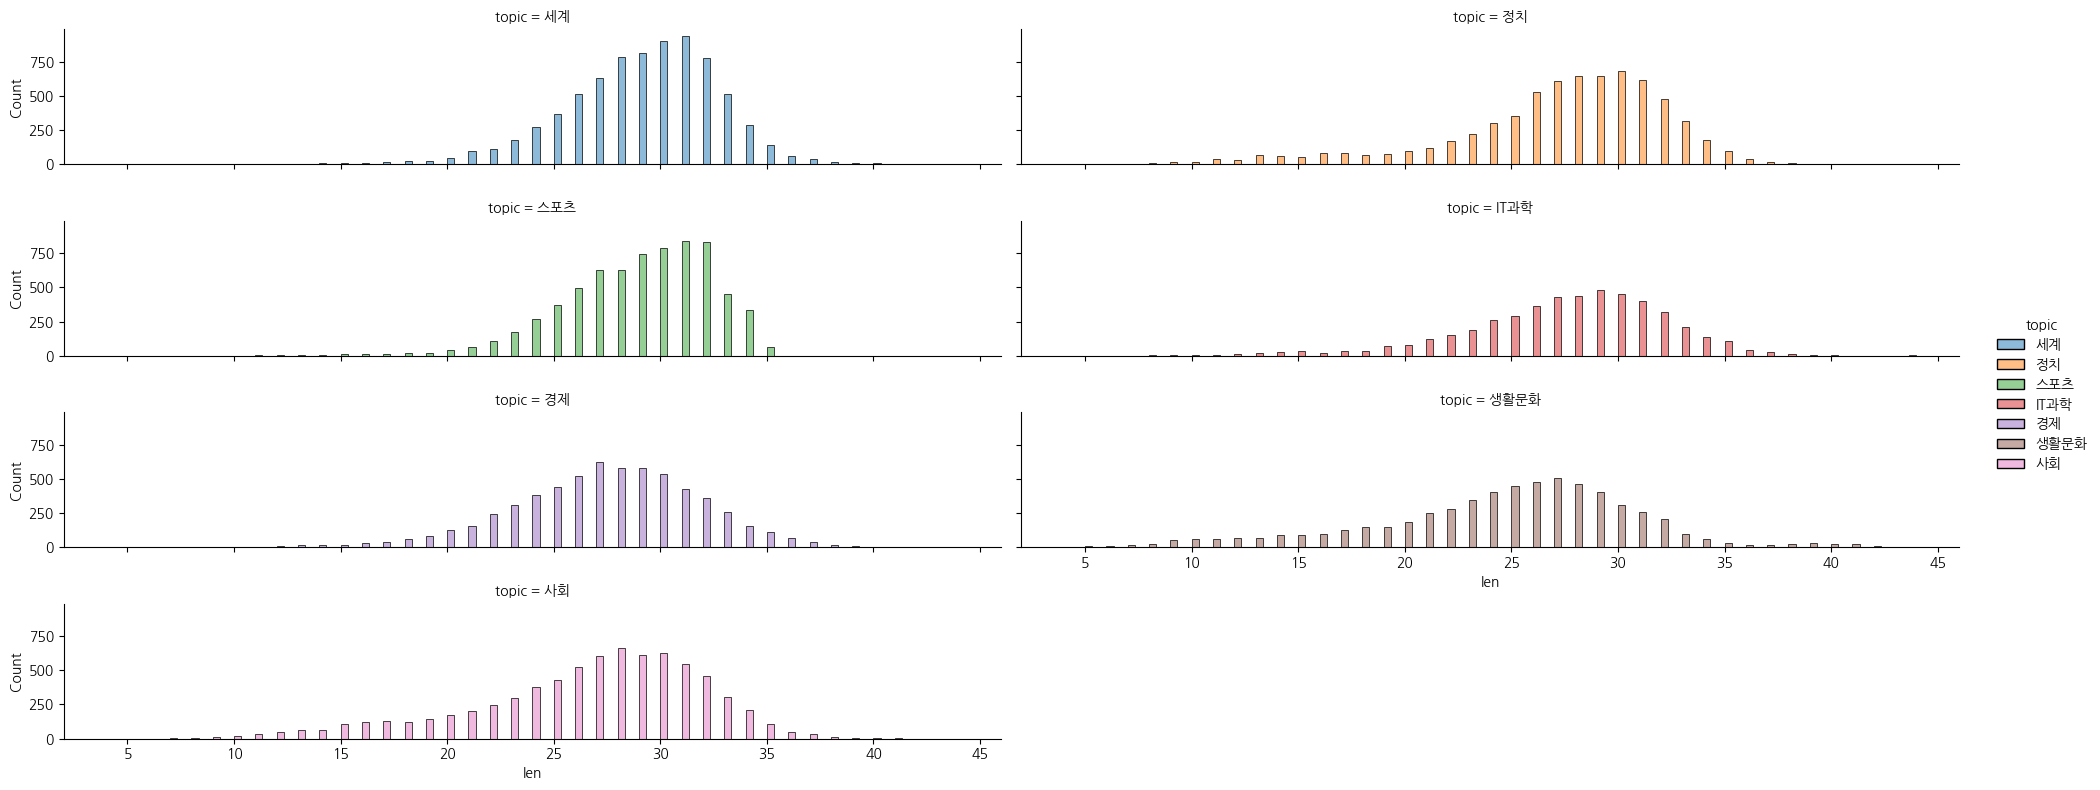

In [27]:
sns.displot(data=df, x="len", hue="topic", kind="hist", col="topic", col_wrap=2, aspect=5, height=2);

- 토픽별로 단어의 분포수를 보면 IT과학, 생활문화는 y축 값이 다른 주제에 비해 빈도가 적음 ==> 그렇다면 정답값의 빈도수는?

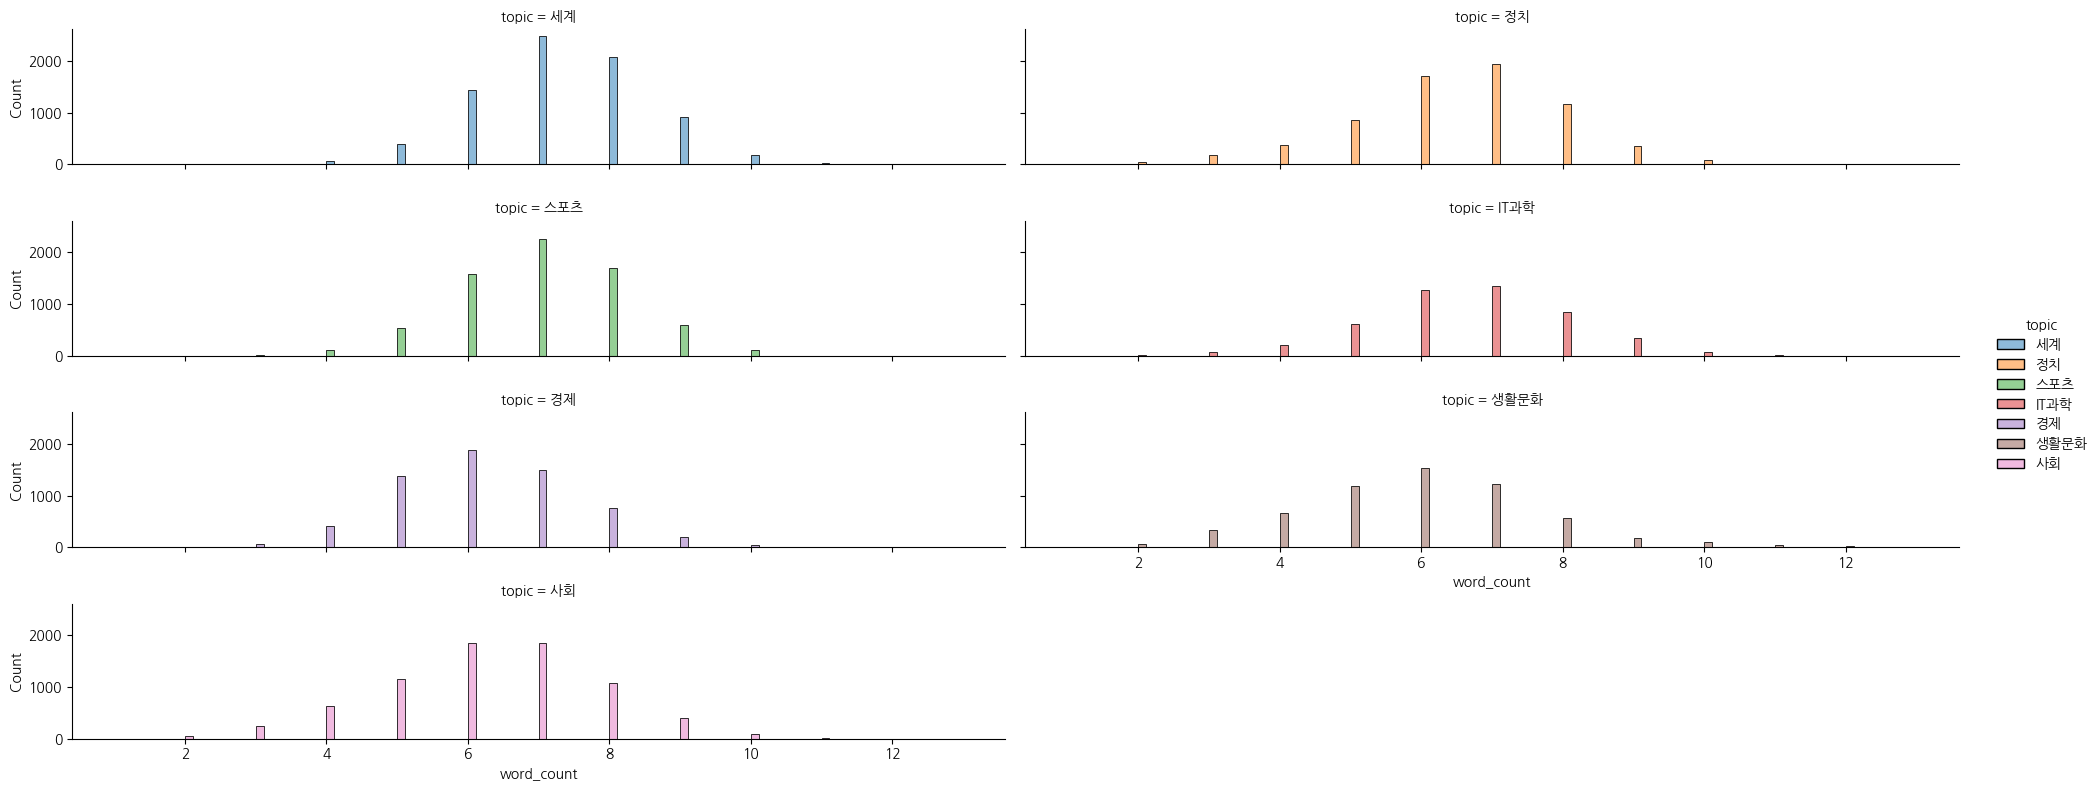

In [28]:
sns.displot(data=df, x="word_count", hue="topic", kind="hist", col="topic", col_wrap=2, aspect=5, height=2);

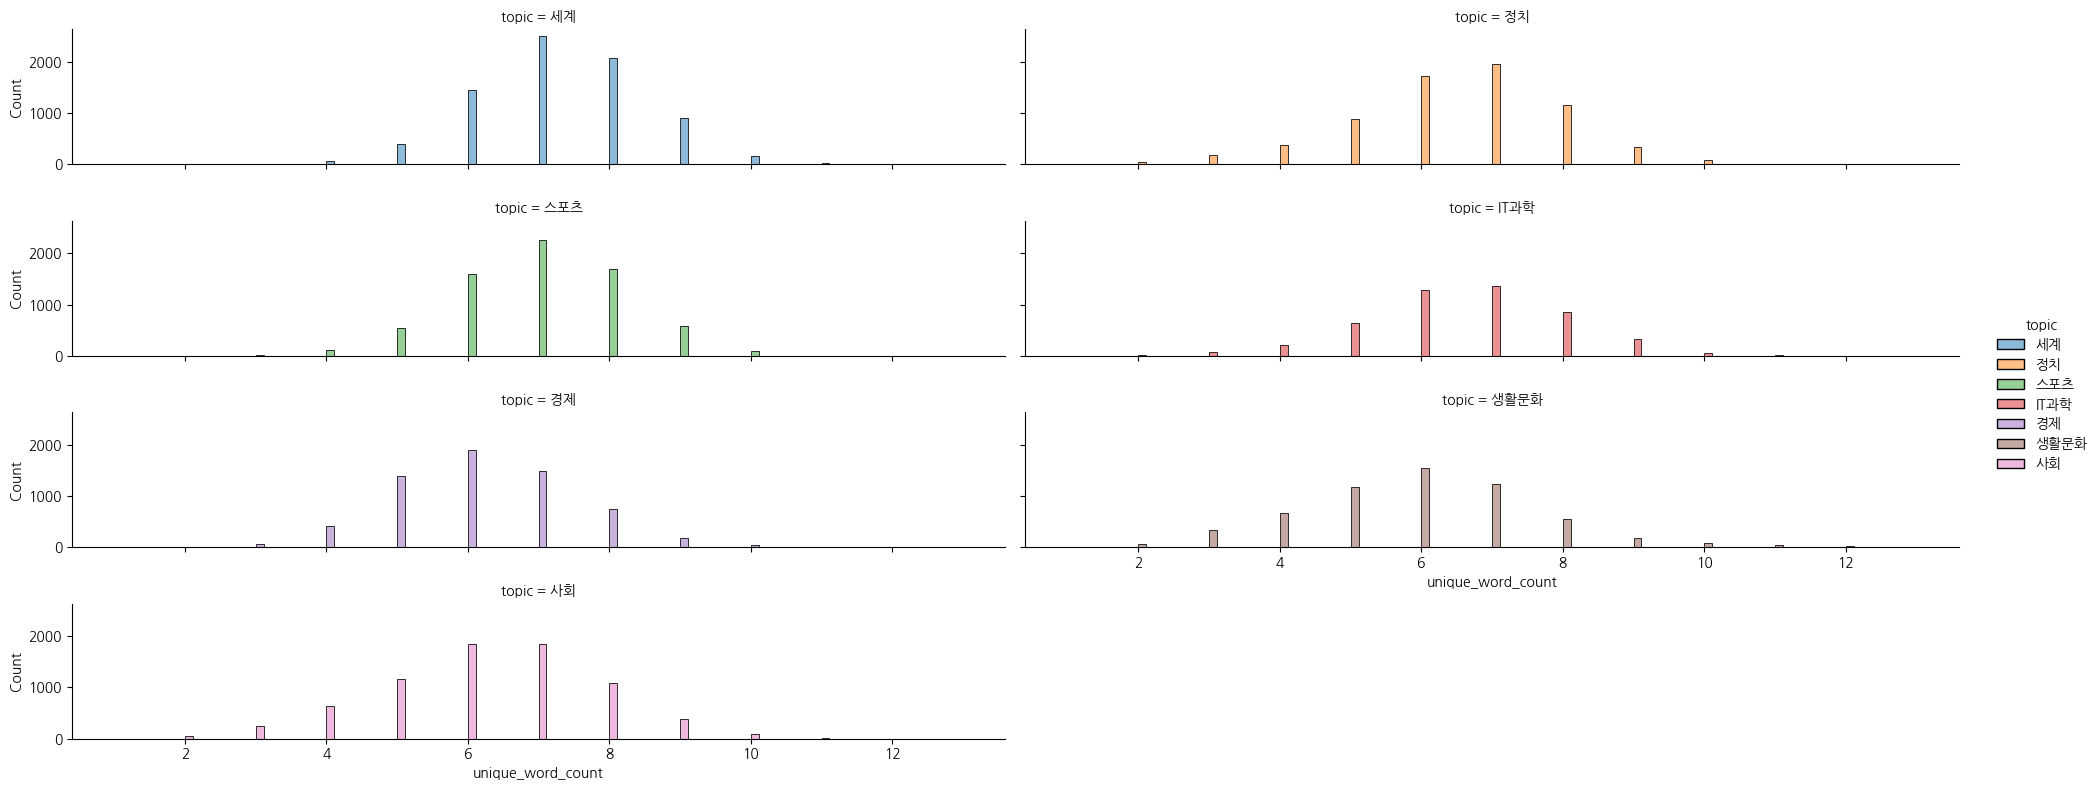

In [29]:
sns.displot(data=df, x="unique_word_count", hue="topic", kind="hist", col="topic", col_wrap=2, aspect=5, height=2);

### 2) 문자 전처리
- 단어의 띄어쓰기 기준으로 벡터화 -> 대소문자에 따라 중복된 단어 사전 생성 됨
- 과적합 발생 ==> 모델 성능 약화
- 문자 전처리 필요(숫자 제거 여부, 영문자 통일, 조사, 어미, 구둣점 제거)

#### 숫자 제거

#### 영문자 소문자 변경


#### 한글, 영문과 공백만 남기고 제거

#### 공백 여러 개는 하나로

#### 불용어 제거

## 형태소 분석을 통한 조사, 구두점 제거
* Pecab
    * [Pecab: Pure python Korean morpheme analyzer based on Mecab (https://github.com/hyunwoongko/pecab)
    
* [형태소 분석 및 품사 태깅 — KoNLPy 0.6.0 documentation](https://konlpy.org/ko/v0.6.0/morph/)
* [Korean POS tags comparison chart - Google Sheets](https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0)

- 에서, 와, 을, . 빠진걸 볼 수 있음

In [30]:
train.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


## 워드 클라우드
- soynlp : 파이썬 만으로 작성된 한국어 분석 도구
  - 비지도학습 지향
  - 신조어 대응

In [31]:
!apt -qq -y install fonts-nanum
from wordcloud import WordCloud


stopwords = []

def display_word_cloud(data, width=1200, height=500):

    word_draw = WordCloud(
        font_path=r"/Library/Fonts/NanumGothic.ttf",
        width=width, height=height,
        stopwords=stopwords,
        background_color="white",
        random_state=42
    )
    word_draw.generate(data)

    plt.figure(figsize=(15, 7))
    plt.imshow(word_draw)
    plt.axis("off")
    plt.show()

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 121925 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


## 특정 토픽 워드 클라우드 시각화